The notebook measures how well learned reward functions generalize to new environments.
It trains a reward function on a series of environments with different colors for the agent and background. It measures how well the reward function can generalize to colors it hasn't seen before.

In [0]:
import gym
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import random
import time
start = time.process_time()
# your code here    


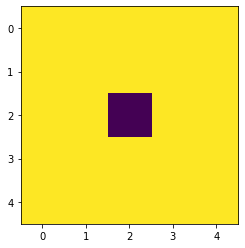

In [2]:
class TransferTestEnv(gym.Env):
  """Makes an environment with one color for the agent and another color for the background.
  Generates the agent in a random position each reset.
  Returns the reward based on how close the agent is to the top right.
  """
  def __init__(self, bg_color, agent_color):
    self.bg_color = bg_color
    self.agent_color = agent_color
    self.color_num = 1
    self.env_size = 5
    pass

  def reset(self):
    self.location = np.random.randint(0, self.env_size, [2])
    color_extra_dim = np.reshape(self.bg_color, [1,1,self.color_num])
    state = np.tile(color_extra_dim, [self.env_size, self.env_size, self.color_num])

    state[self.location[0], self.location[1]] = self.agent_color

    reward = self.location[0] + self.location[1]

    return state, reward

state, reward = TransferTestEnv(5, 1).reset()
plt.imshow(np.squeeze(state))


In [0]:
def generate_data(dataset_size, env_params_list):
  """Generates data by randomly sampling from environments with the specified parameters.""" 
  xs = []
  ys = []
  for _ in range(dataset_size):
    env_params = random.choice(env_params_list)
    state, reward = TransferTestEnv(*env_params).reset()
    xs.append(state)
    ys.append(reward)

  xs = np.array(xs)
  ys = np.array(ys)

  return xs, ys

In [4]:
#------small problem (can be ignored): a not balanced amount of environemnts generated every type of setup
xs, ys = generate_data(10, [[1.111111, -.1111111],[1.111, -.111], [1,0]])
print(xs.shape)
print(ys.shape)
[m[1,1] for m in xs]

(10, 5, 5, 1)
(10,)


[array([1.]),
 array([1.]),
 array([1.]),
 array([1.]),
 array([1.]),
 array([1.111]),
 array([1.111]),
 array([1.111111]),
 array([-0.111]),
 array([1.111111])]

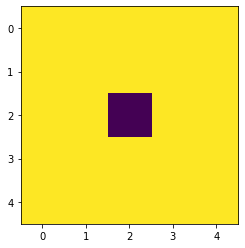

In [5]:
plt.imshow(np.squeeze(xs[0]))

In [6]:
# Creates parameters with different background and foreground colors. Make sure that the colors are different enough

max_num_envs = 40

while True:
  half_max_num_envs = int(max_num_envs/2)
  train_env_params = np.random.random(size=(half_max_num_envs, 2))
  train_env_params = np.concatenate((np.array([[pair[0]+1.2, pair[1]-1.2] for pair in train_env_params]), np.random.random(size=(half_max_num_envs, 2))))
  diff = np.abs(train_env_params[:, 0] - train_env_params[:, 1])

  if np.min(diff) > .2:
    break
print(train_env_params.shape)
print(train_env_params)


(40, 2)
[[ 2.11339653 -0.93768508]
 [ 2.1716916  -0.87014043]
 [ 1.43785683 -0.99034001]
 [ 1.97963566 -0.88127797]
 [ 1.33988734 -1.0706228 ]
 [ 1.27157081 -0.27157156]
 [ 1.32446151 -0.9377962 ]
 [ 1.70463084 -0.4724057 ]
 [ 1.92371373 -1.11574427]
 [ 1.94445758 -1.17275503]
 [ 1.51234269 -0.37481796]
 [ 1.85709828 -0.60913655]
 [ 1.50366587 -0.5543212 ]
 [ 1.62932566 -1.11358714]
 [ 1.25225586 -0.31860369]
 [ 1.37449072 -0.22511138]
 [ 1.39422275 -0.78325376]
 [ 1.25090576 -0.36054151]
 [ 1.2827876  -0.2896361 ]
 [ 2.03657605 -0.98174992]
 [ 0.12667257  0.89199953]
 [ 0.834253    0.36008548]
 [ 0.96693703  0.39090807]
 [ 0.73729006  0.32307401]
 [ 0.0912046   0.70161257]
 [ 0.12514427  0.59779059]
 [ 0.1585461   0.37119134]
 [ 0.42373785  0.63724956]
 [ 0.70146444  0.35857631]
 [ 0.10294552  0.47611897]
 [ 0.72503521  0.09307338]
 [ 0.77532211  0.20371545]
 [ 0.91491922  0.09418495]
 [ 0.77110822  0.38431819]
 [ 0.02354396  0.59713434]
 [ 0.63714291  0.12260265]
 [ 0.98436413  0.736

In [7]:
np.concatenate((np.array([1,23]),np.array([1,23])))
# np.array([1,23])

array([ 1, 23,  1, 23])

In [0]:
def get_generalization_amount(train_env_params):
  xs, ys = generate_data(1000, train_env_params)
  print("train_env_params", train_env_params)

  #Model architecture
  model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(16, (3, 3), activation='relu', input_shape=xs.shape[1:]),
    tf.keras.layers.Conv2D(16, (3, 3), activation='relu'),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64),
  ])
  model.compile(optimizer='adam', loss='mse')
  # Train the model on the data.
  model.fit(xs, ys, epochs=400, verbose=0)

  xs_val, ys_val = generate_data(1000, train_env_params)
  xs_val_differnt, ys_val_different = generate_data(1000, [(1.1, -.1)])

  model.evaluate(xs, ys)
  # This is the loss from different data on the same environments.
  val_loss = model.evaluate(xs_val, ys_val)
  # This is the loss from different data on different environments.
  different_loss = model.evaluate(xs_val_differnt, ys_val_different)

  return val_loss, different_loss

In [9]:
# Get the val and generalization losses using different numbers of environments.
gaps_for_nums = []
num_envs_ar = list(range(1, max_num_envs))
val_loss_ar = []
different_loss_ar = []
for num_envs in num_envs_ar:
  val_loss, different_loss = get_generalization_amount(train_env_params[:num_envs])

  val_loss_ar.append(val_loss)
  different_loss_ar.append(different_loss)

  print([num_envs, val_loss, different_loss])

val_loss_ar = np.array(val_loss_ar)
different_loss_ar = np.array(different_loss_ar)

train_env_params [[ 2.11339653 -0.93768508]]
32/32 [==============================] - 0s 1ms/step - loss: 3.3791
[1, 0.12689432501792908, 3.3790977001190186]
train_env_params [[ 2.11339653 -0.93768508]
 [ 2.1716916  -0.87014043]]
32/32 [==============================] - 0s 1ms/step - loss: 2.1755
[2, 0.0980101153254509, 2.175467014312744]
train_env_params [[ 2.11339653 -0.93768508]
 [ 2.1716916  -0.87014043]
 [ 1.43785683 -0.99034001]]
32/32 [==============================] - 0s 1ms/step - loss: 1.1360
[3, 0.04257044568657875, 1.136009693145752]
train_env_params [[ 2.11339653 -0.93768508]
 [ 2.1716916  -0.87014043]
 [ 1.43785683 -0.99034001]
 [ 1.97963566 -0.88127797]]
32/32 [==============================] - 0s 1ms/step - loss: 1.4429
[4, 0.1466187834739685, 1.4428919553756714]
train_env_params [[ 2.11339653 -0.93768508]
 [ 2.1716916  -0.87014043]
 [ 1.43785683 -0.99034001]
 [ 1.97963566 -0.88127797]
 [ 1.33988734 -1.0706228 ]]
32/32 [==============================] - 0s 1ms/step - lo

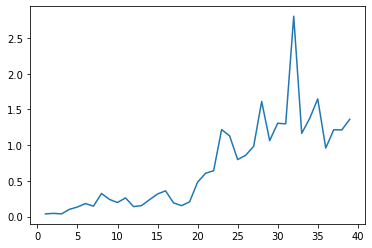

In [10]:
gaps = val_loss_ar / different_loss_ar
# Plot the ratio of loss on the data from the same environments vs different environments. Higher is better.
# X axis is the number of training environments.
plt.plot(num_envs_ar, gaps)

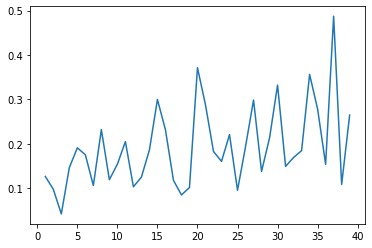

In [11]:
plt.plot(num_envs_ar, val_loss_ar)

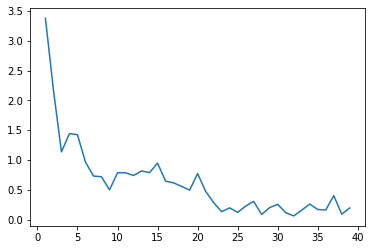

In [12]:
plt.plot(num_envs_ar, different_loss_ar)

In [13]:
print("time spent (min):", (time.process_time() - start)/60)

time spent (min): 18.850537759250003
